<a href="https://colab.research.google.com/github/sirakik/japan_graph/blob/master/japan_graph_%E6%9C%AA%E6%9D%A5%E4%BA%88%E6%83%B3%E5%9B%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#モジュール

---



---



In [460]:
pip install dgl \
pip install networkx

In [461]:
import csv
import pickle
import datetime
import numpy as np
import dgl
import networkx as nx
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.nn.functional as F

#日本グラフ

---



---



##日本データ

In [462]:
# 都道府県名
todofuken = {0:'Hokkaido', 1:'Aomori', 2:'Iwate', 3:'Miyagi', 4:'Akita', 5:'Yamagata', 6:'Fukushima', 7:'Ibaraki', 8:'Tochigi', 9:'Gumma', 10:'Saitama',
              11:'Chiba', 12:'Tokyo', 13:'Kanagawa', 14:'Niigata', 15:'Toyama', 16:'Ishikawa', 17:'Fukui', 18:'Yamanashi', 19:'Nagano', 20:'Gifu',
              21:'Shizuoka', 22:'Aichi', 23:'Mie', 24:'Shiga', 25:'Kyoto', 26:'Osaka', 27:'Hyogo', 28:'Nara', 29:'Wakayama', 30:'Tottori', 
              31:'Shimane', 32:'Okayama', 33:'Hiroshima', 34:'Yamaguchi', 35:'Tokushima', 36:'Kagawa', 37:'Ehime', 38:'Kochi', 39:'Fukuoka', 40:'Saga', 
              41:'Nagasaki', 42:'Kumamoto', 43:'Oita', 44:'Miyazaki', 45:'Kagoshima', 46:'Okinawa'}

# 県庁所在地 緯度経度
todofukencho_xy = {0:(43.06417,141.34694), 1:(40.82444,140.74), 2:(39.70361,141.1525), 3:(38.26889,140.87194), 4:(39.71861,140.1025), 5:(38.24056,140.36333),
                     6:(37.75,140.46778), 7:(36.34139,140.44667), 8:(36.56583,139.88361), 9:(36.39111,139.06083), 10:(35.85694,139.64889), 
                     11:(35.60472,140.12333), 12:(35.68944,139.69167), 13:(35.44778,139.6425), 14:(37.90222,139.02361), 15:(36.69528,137.21139),
                     16:(36.59444,136.62556), 17:(36.06528,136.22194), 18:(35.66389,138.56833), 19:(36.65139,138.18111), 20:(35.39111,136.72222),
                     21:(34.97694,138.38306), 22:(35.18028,136.90667), 23:(34.73028,136.50861), 24:(35.00444,135.86833), 25:(35.02139,135.75556),
                     26:(34.68639,135.52), 27:(34.69139,135.18306), 28:(34.68528,135.83278), 29:(34.22611,135.1675), 30:(35.50361,134.23833), 
                     31:(35.47222,133.05056), 32:(34.66167,133.935), 33:(34.39639,132.45944), 34:(34.18583,131.47139), 35:(34.06583,134.55944), 
                     36:(34.34028,134.04333), 37:(33.84167,132.76611), 38:(33.55972,133.53111), 39:(33.60639,130.41806), 40:(33.24944,130.29889), 
                     41:(32.74472,129.87361), 42:(32.78972,130.74167), 43:(33.23806,131.6125), 44:(31.91111,131.42389), 45:(31.56028,130.55806), 46:(26.2125,127.68111)}


def find_key(value): # 都道府県名を番号に変換
    for k, v in todofuken.items():
        if value == v:
          return k

##ループエッジ

In [463]:
#roop_edge = [(i, i) for i in range(len(todofuken))]

##陸路エッジ

---



In [464]:
# 陸路エッジ：陸路で通れる場合はエッジあり(例：北海道と青森)
rikuro_edge = [(0, 1), (1, 2), (1, 4), (2, 4), (2, 7), (3, 4), (3, 5), (3, 6), (4, 5), (5, 6), (5, 14), (6, 7), (6, 8), (6, 9), (6, 14), (7, 8),
               (7, 10), (7, 11), (8, 9), (8, 10), (9, 10), (9, 14), (9, 19), (10, 11), (10, 12), (10, 18), (10, 19), (11, 12), (11, 13),
               (12, 13), (12, 18), (13, 18), (13, 21), (14, 15), (14, 19), (15, 16), (15, 19), (15, 20), (16, 17), (16, 20), (17, 20), (17, 24), (17, 25), 
               (18, 19), (18, 21), (19, 20), (19, 21), (19, 22), (20, 22), (20, 23), (20, 24), (21, 22), (22, 23), (23, 24), (23, 25), (23, 28), (23, 29),
               (24, 25), (25, 26), (25, 27), (25, 28), (26, 27), (26, 28), (26, 29), (27, 30), (27, 32), (27, 35), (28, 29), (30, 31), (30, 32), (30, 33),
               (31, 33), (31, 34), (32, 33), (32, 36), (33, 34), (33, 37), (34, 39), (35, 36), (35, 37), (35, 38), (36, 37), (37, 38), (39, 40), (39, 42), (39, 43),
               (40, 41), (42, 43), (42, 44), (42, 45), (43, 44), (44, 45)]
print('陸路エッジ数: ', len(rikuro_edge))

陸路エッジ数:  92


/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


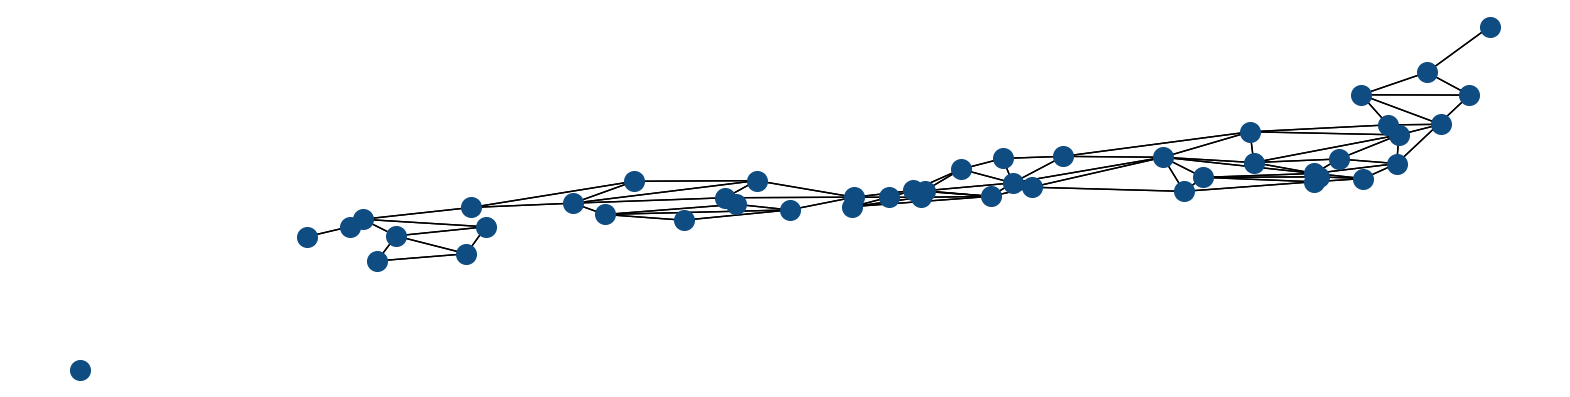

In [465]:
# 日本グラフ作成
japan_g = dgl.DGLGraph()
japan_g.add_nodes(len(todofuken))

# 陸路edgeを追加 
src, dst = tuple(zip(*rikuro_edge))
japan_g.add_edges(src, dst)
japan_g.add_edges(dst, src)

# 描画
# 枠線消し
ax = plt.gca() # get current axis
ax.spines["right"].set_color("none") 
ax.spines["left"].set_color("none") 
ax.spines["top"].set_color("none")  
ax.spines["bottom"].set_color("none")
#ax.set_facecolor('#000000')

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['figure.dpi'] = 100
nx_japan_g = japan_g.to_networkx()
pos_ = {n: (todofukencho_xy[n][1], todofukencho_xy[n][0]) for n in range(len(todofuken))}
nx.draw_networkx(nx_japan_g, pos=pos_, arrows=False, node_size=200, with_labels=False, labels=todofuken, node_color='#0F4C81', edge_color='#000000')
#nx.draw_networkx(nx_japan_g, pos=pos_, arrows=False, node_size=200, with_labels=False, labels=todofuken, node_color='#81D8D0', edge_color='#81D8D0')
plt.show()

## 航空路エッジ

---



航空路がある空港を接続  
国土交通省　国土数値情報｜空港間流通量　[ https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-S10b-v1_1.html ]   
平成26年(2014)  
全ての空港間の旅客数などが入っている


少し手作業でいじったデータ(xmlファイル)を白木githubに保管中
- 手作業での編集内容
  - 国際便のデータを削除
  - 空港座標を削除
  - url情報を削除

In [466]:
# 白木のgithubからダウンロード
!wget -q https://raw.githubusercontent.com/sirakik/japan_graph/master/airport_data.xml -O airport.xml

airport_xml = ET.parse('airport.xml')
root = airport_xml.getroot()

空港間の旅客数を, 県間の旅客数に変換

In [467]:
# 各都道府県の空港名
airport={0:['稚内', '利尻', '旭川', '紋別', '女満別', '中標津', '釧路', '帯広', '丘珠', '函館', '新千歳', '奥尻'], 1:['青森', '三沢'], 2:['花巻'], 3:['仙台'], 4:['秋田', '大館'], 5:['庄内', '山形'], 
         6:['福島'], 7:['茨城'], 8:[], 9:[], 10:[], 11:['成田'], 12:['東京', '調布', '大島', '新島', '神津島', '三宅島', '八丈島', '利島', '御蔵島', '青ヶ島'], 13:[], 14:['新潟'], 15:['富山'], 
         16:['小松', '能登', '金沢'], 17:[], 18:[], 19:['松本'], 20:[], 21:['静岡'], 22:['名古屋', '中部'], 23:[], 24:[], 25:[], 26:['大阪', '関西'], 27:['神戸', '但馬'], 28:[], 
         29:['南紀白浜'], 30:['鳥取', '米子'], 31:['出雲', '隠岐', '石見'], 32:['岡山'], 33:['広島'], 34:['山口宇部', '岩国'], 35:['徳島'], 36:['高松'], 37:['松山'], 38:['高知'], 
         39:['北九州', '福岡'], 40:['佐賀', '対馬', '壱岐', '福江'], 41:['長崎'], 42:['熊本', '天草'], 43:['大分'], 44:['宮崎'], 
         45:['鹿児島', '種子島', '屋久島', '奄美', '喜界島', '徳之島', '沖永良部', '与論'], 46:['那覇', '粟国', '久米島', '北大東島', '南大東島', '宮古', '下地島', '多良間', '石垣', '与那国']}

def find_airport(value):
    for k, v in airport.items():
        if value in v:
          return k

In [468]:
pas_matrix = np.zeros((47, 47)) # 累計旅客数カウント用
for n in range(0, len(root), 2): # 東京->新千歳, 新千歳->東京のようにひっくり返したものが連続するので1つ飛ばしする
    dep = root[n].find('depAport').text # 出発空港
    arr = root[n].find('arrAport').text # 到着空港
    frequency = int(root[n].find('distAirRt').text) #頻度 週当たりの本数
    try:
      pas = int(root[n].find('numOfPass').text) # 年間旅客数
    except:
      continue
    
    # 空港を都道府県番号に変換
    dep_key = find_airport(dep)
    arr_key = find_airport(arr)
    
    if dep_key == arr_key: # 県内移動は無視
        continue
    
    if dep_key > arr_key:
        x = arr_key
        y = dep_key
    else:
        x = dep_key
        y = arr_key
    
    # 旅客数を加算
    pas_matrix[x][y] += pas

エッジを作成
- few_pas_edge：年間旅客数が少ない航空路のエッジ (0 < 旅客数 <= 閾値)  
- many_pas_edge：年間旅客数が多い航空路のエッジ (閾値　< 旅客数)

In [469]:
# 旅客数の多さによってグラフを構築

S = 100000 
# 0<旅客数<=S　を　few_pas_graph
# S<旅客数 を many_pas_graph

few_pas_edge = []
many_pas_edge = []
for i, n in enumerate(pas_matrix.flatten()):
    x = i // 47
    y = i % 47
    if (0 < n) & (n <= S):
        few_pas_edge.append((x, y))
    elif (S < n):
        many_pas_edge.append((x, y))
    else:
      pass

print('# few_pas_edge数:', len(few_pas_edge))
print('# few_pas_edge:', few_pas_edge)
print('# many_pas_edge数:', len(many_pas_edge))
print('# many_pas_edge:', many_pas_edge)

# few_pas_edge数: 74
# few_pas_edge: [(0, 1), (0, 2), (0, 4), (0, 6), (0, 7), (0, 14), (0, 15), (0, 16), (0, 19), (0, 21), (0, 32), (0, 33), (0, 46), (1, 22), (1, 26), (2, 22), (2, 26), (2, 39), (3, 11), (3, 16), (3, 33), (3, 46), (4, 22), (4, 26), (5, 26), (6, 26), (7, 27), (7, 30), (7, 46), (11, 14), (11, 16), (11, 30), (11, 33), (11, 36), (11, 37), (11, 43), (11, 45), (12, 22), (12, 29), (14, 22), (14, 39), (14, 46), (16, 39), (16, 46), (19, 39), (21, 39), (21, 45), (21, 46), (22, 37), (22, 38), (22, 41), (22, 43), (22, 44), (26, 27), (26, 31), (26, 43), (27, 30), (27, 41), (27, 45), (31, 39), (32, 46), (33, 46), (35, 39), (36, 46), (37, 39), (37, 45), (37, 46), (38, 39), (39, 42), (39, 45), (40, 41), (41, 46), (42, 46), (44, 46)]
# many_pas_edge数: 56
# many_pas_edge: [(0, 3), (0, 11), (0, 12), (0, 22), (0, 26), (0, 27), (0, 39), (1, 12), (3, 22), (3, 26), (3, 39), (4, 12), (5, 12), (11, 22), (11, 26), (11, 39), (11, 46), (12, 15), (12, 16), (12, 26), (12, 27), (12, 30), (12, 31), (1

グラフ化

In [470]:
# DGLでの複数の隣接行列を与える方法が分からない R-GCNがあったからできそう...あとで調べる.

# few_pas_graph
few_pas_g = dgl.DGLGraph()
few_pas_g.add_nodes(len(todofuken))
# few pas edgeを追加 
src, dst = tuple(zip(*few_pas_edge))
few_pas_g.add_edges(src, dst)
few_pas_g.add_edges(dst, src)

# many pas graph
many_pas_g = dgl.DGLGraph()
many_pas_g.add_nodes(len(todofuken))
# many pas edgeを追加 
src, dst = tuple(zip(*many_pas_edge))
many_pas_g.add_edges(src, dst)
many_pas_g.add_edges(dst, src)

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


可視化

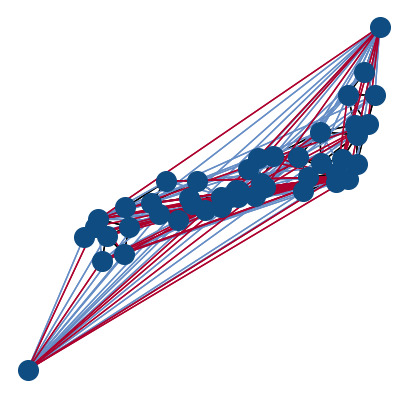

In [471]:
# 枠線消し
ax = plt.gca() # get current axis
ax.spines["right"].set_color("none") 
ax.spines["left"].set_color("none") 
ax.spines["top"].set_color("none")  
ax.spines["bottom"].set_color("none")

plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams['figure.dpi'] = 100
nx.draw_networkx(nx_japan_g, pos=pos_, arrows=False, node_size=200, with_labels=False, labels=todofuken, node_color='#0F4C81', edge_color='#000000')
nx.draw_networkx_edges(few_pas_g.to_networkx(), pos=pos_, arrows=False, edge_color='#658DC6') # 青: few_pas_edge
nx.draw_networkx_edges(many_pas_g.to_networkx(), pos=pos_, arrows=False, edge_color='#AD002D') # 赤: many_pas_edge
plt.show()

#今日または昨日または一昨日または....

In [472]:
dt2 = datetime.date(year=2021, month=1, day=16)

# ノード特徴

---



---



## 人口 (population), 人口密度 (population_density)

---





- 人口[人]  
総務省統計局 [ https://www.stat.go.jp/data/nihon/zuhyou/n200200200.xlsx ]   
平成27年(2015),国勢調査にもとづく

- 人口密度[人/km^2]  
出典は上記と同様  

国土交通省GISホームページ　[ https://nlftp.mlit.go.jp/index.html ]  
お世話になっております.

In [473]:
# 人口[人]  
population = [5382000, 1308000, 1280000, 2334000, 1023000, 1124000, 1914000, 2917000, 1974000, 1973000, 7267000, 6223000, 13515000, 9126000, 2304000, 1066000, 1154000, 787000, 835000, 2099000, 2032000, 3700000, 7483000, 1816000, 1413000, 2610000, 8839000, 5535000, 1364000, 964000, 573000, 694000, 1922000, 2844000, 1405000, 756000, 976000, 1385000, 728000, 5102000, 833000, 1377000, 1786000, 1166000, 1104000, 1648000, 1434000]
# 人口密度[人/km^2] 
population_density = [68.6, 135.6, 83.8, 320.5, 87.9, 120.5, 138.9, 478.4, 308.1, 310.1, 1913.4, 1206.5, 6168.7, 3777.7, 183.1, 251.0, 275.7, 187.7, 187.0, 154.8, 191.3, 475.8, 1446.7, 314.5, 351.7, 566.0, 4639.8, 658.8, 369.6, 203.9, 163.5, 103.5, 270.1, 335.4, 229.8, 182.3, 520.2, 244.1, 102.5, 1023.1, 341.2, 333.3, 241.1, 183.9, 142.7, 179.4, 628.4]

##コロナ感染者データ

---



東洋経済ONLINE [ https://toyokeizai.net/sp/visual/tko/covid19/ ]  
感染者データなどのCSVファイルをgithubで公開してくださっている [ https://github.com/kaz-ogiwara/covid19/ ]（おそらく毎日更新）

In [474]:
# githubからダウンロード
!wget -q https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/prefectures.csv -O corona.csv

In [475]:
#　日数を指定
dt1 = datetime.date(year=2020, month=2, day=8) #　2月8日からデータが始まっています
#dt2 = datetime.date(year=2021, month=1, day=16) # ほぼ毎日更新っぽいので，今日の日付に合わせましょう．ただし何時更新かは知らないので，手作業で合わせてください
dif_days = (dt2 - dt1).days +1
print('#　日数: ', dif_days)

#　日数:  344


In [476]:
# 都道府県名 (データに合わせて, GummaをGunmaに変更)
todofuken_v2 = {0:'Hokkaido', 1:'Aomori', 2:'Iwate', 3:'Miyagi', 4:'Akita', 5:'Yamagata', 6:'Fukushima', 7:'Ibaraki', 8:'Tochigi', 9:'Gunma', 10:'Saitama', 
                  11:'Chiba', 12:'Tokyo', 13:'Kanagawa', 14:'Niigata', 15:'Toyama', 16:'Ishikawa', 17:'Fukui', 18:'Yamanashi', 19:'Nagano', 20:'Gifu', 
                  21:'Shizuoka', 22:'Aichi', 23:'Mie', 24:'Shiga', 25:'Kyoto', 26:'Osaka', 27:'Hyogo', 28:'Nara', 29:'Wakayama', 30:'Tottori', 
                  31:'Shimane', 32:'Okayama', 33:'Hiroshima', 34:'Yamaguchi', 35:'Tokushima', 36:'Kagawa', 37:'Ehime', 38:'Kochi', 39:'Fukuoka', 40:'Saga', 
                  41:'Nagasaki', 42:'Kumamoto', 43:'Oita', 44:'Miyazaki', 45:'Kagoshima', 46:'Okinawa'}

def find_key_v2(value):
    for k, v in todofuken_v2.items():
        if value == v:
          return k

新規感染者数 (daily_infected)

In [477]:
daily_infected = np.zeros((47, dif_days))
last_discharged = np.zeros(47)
with open('corona.csv') as f:
    corona_data = csv.reader(f)
    # ヘッダー削除
    next(corona_data)
    for i, d in enumerate(corona_data):
        # 都道府県番号を取得
        key = find_key_v2(d[4])
        # 日付を配列番号に変更
        dt = datetime.date(year=int(d[0]), month=int(d[1]), day=int(d[2]))
        index = (dt - dt1).days
        # 新規感染者数を格納
        daily_infected[key][index] = float(d[5])
        
# 累計感染者が減ることがある. 減った場合は新規感染者数を0とした.
last_infected = daily_infected[:, 0:1].flatten()
for key, todo in enumerate(daily_infected):
    for n, d in enumerate(todo):
        if n == 0:
            continue
        dis = d - last_infected[key]
        if dis < 0:
            dis = 0
        daily_infected[key][n] = dis
        last_infected[key] = d

検査数 (daily_tested)

In [478]:
daily_tested = np.zeros((47, dif_days))
with open('corona.csv') as f:
    corona_data = csv.reader(f)
    # ヘッダー削除
    next(corona_data)
    for i, d in enumerate(corona_data):
        # 都道府県番号を取得
        key = find_key_v2(d[4])
        # 日付を配列番号に変更
        dt = datetime.date(year=int(d[0]), month=int(d[1]), day=int(d[2]))
        index = (dt - dt1).days
        # 新規検査数を格納
        if d[6] == '':
            continue
        else:
            daily_tested[key][index] = float(d[6])

# その日のデータがない場合, 前日の検査数と同じにする（あんまりよくない?）
last_tested = daily_tested[:, 0:1].flatten()
for key, todo in enumerate(daily_tested):
    for n, d in enumerate(todo):
        if n == 0:
            continue
        if last_tested[key] == d:
            daily_tested[key][n] = daily_tested[key][n-1]
        else:
            daily_tested[key][n] = d - last_tested[key]
            last_tested[key] = d

感染率 (daily_rate)

In [479]:
daily_rate = (daily_infected / daily_tested)

# 感染者0でも検査数がN 0/N = nan :感染率を0とする
daily_rate = np.where(np.isnan(daily_rate), 0, daily_rate)

#　感染者数がいるのに，検査数が0のとき N/0 = inf
# 前日と同じとする. 前日がない2月8日は強制的に感染率を0とする.
for key, todo in enumerate(daily_rate):
    for i, d in enumerate(todo):
        if d == np.inf:
            if i != 0:
                daily_rate[key][i] = daily_rate[key][i-1]
            else:
                daily_rate[key][i] = 0.0

# 感染者数 > 検査数の場合は確率を1.0にする.
daily_rate = np.where(daily_rate > 1.0, 1.0, daily_rate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


可視化

# 新規感染者数


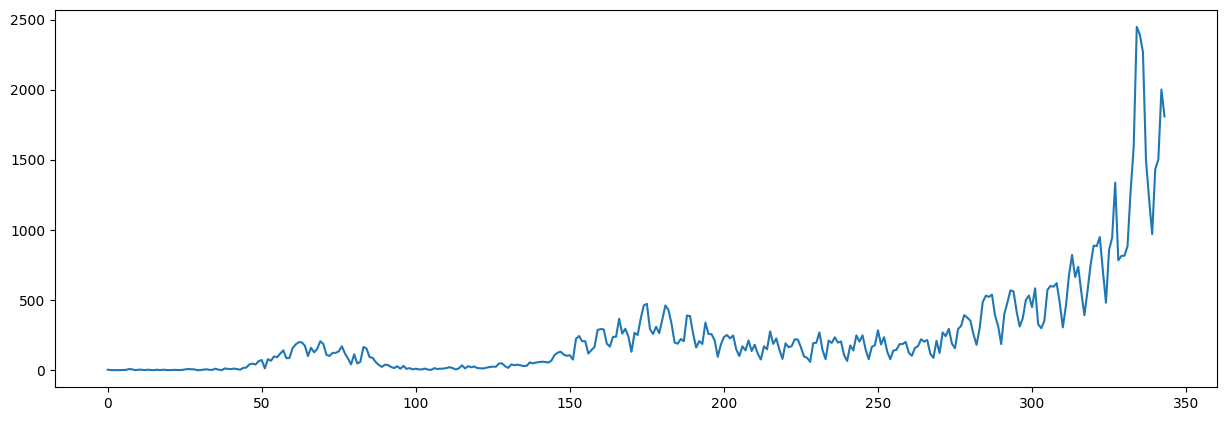

# 新規検査数 : 日曜日は検査数が減ります


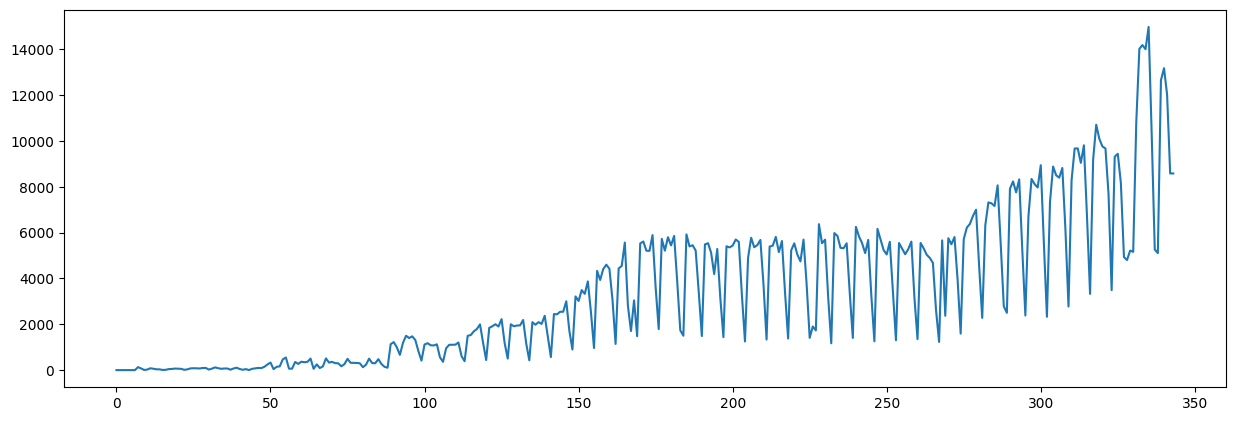

# 感染率 (感染者数 / 検査数)


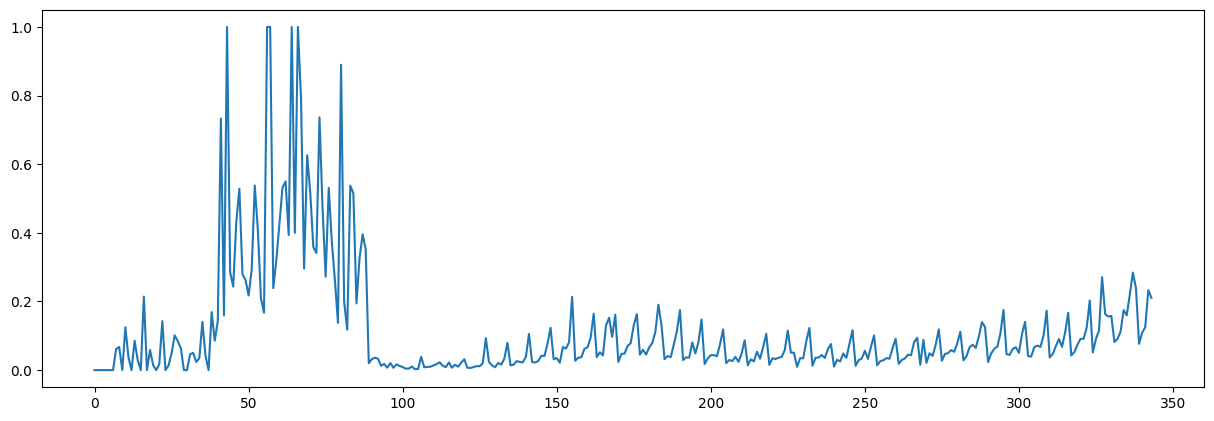

In [480]:
sam = 'Tokyo'

plt.rcParams['figure.figsize'] = (15.0, 5.0)

key = find_key(sam)
if key is None:
  raise ValueError('# 都道府県名が正しくないね:)')
x = list(range(dif_days))

print('# 新規感染者数')
y = daily_infected[key]
plt.plot(x, y)
plt.show()

print('# 新規検査数 : 日曜日は検査数が減ります')
y = daily_tested[key]
plt.plot(x, y)
plt.show()

print('# 感染率 (感染者数 / 検査数)')
y = daily_rate[key]
plt.plot(x, y)
plt.show()
plt.rcParams['figure.figsize'] = (15.0, 15.0)

感染率はもう少し滑らかになるかと．．．．  
特に第一波の頃の検査数の報告が正確にされていないのでは?  
感染率が1を越えることがかなりある．

感染者予測が妥当かと..


# 学習&評価データ作成

---



---



ここ苦手


In [481]:
train_size = 0.8 # 学習データの割合
in_days = 14
out_days = 7
days = in_days + out_days
#データ選べ
DATA = daily_infected

##処理

In [482]:
# ０〜１に正規化
#norm_data = DATA
min_data = min(DATA.flatten())
max_data = max(DATA.flatten())
norm_data = (DATA - min_data) / (max_data - min_data)

In [483]:
# 学習と評価に分割
train_days = int(norm_data.shape[1] * train_size)
train_data = norm_data[:, :train_days+out_days]
test_data = norm_data[:, train_days-in_days:]

# 学習：xとy
train_x = []
train_y = []
for i in range(train_data.shape[1]-days):
    f = train_data[:, i:i+days]
    train_x.append(f[:, 0:in_days])
    train_y.append(f[:, in_days:])

# 評価：xとy
test_x = []
test_y = []
for i in range(test_data.shape[1]-days):
    f = test_data[:, i:i+days]
    test_x.append(f[:, 0:in_days])
    test_y.append(f[:, in_days:])

In [484]:
# (N, 都道府県数, データ)に変換
train_x = np.array(train_x).transpose(0, 2, 1)
train_y = np.array(train_y).transpose(0, 2, 1)
test_x = np.array(test_x).transpose(0, 2, 1)
test_y = np.array(test_y).transpose(0, 2, 1)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# 保存
np.save('train_x.npy', train_x)
np.save('train_y.npy', train_y)
np.save('test_x.npy', test_x)
np.save('test_y.npy', test_y)

(261, 14, 47)
(261, 7, 47)
(62, 14, 47)
(62, 7, 47)


### データセットの読み込み関数



In [485]:
class Feeder(torch.utils.data.Dataset):
    def __init__(self, data_path, label_path):
        super(Feeder, self).__init__()
        self.data = np.load(data_path)
        self.label = np.load(label_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        label = self.label[index]
        return data, label

#隣接行列

In [486]:
def normalize_undigraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-0.5)
    DAD = np.dot(np.dot(Dn, A), Dn)
    return DAD

In [487]:
roop_A = np.eye(len(todofuken), len(todofuken)) #ループエッジ
rikuro_A = normalize_undigraph(japan_g.adjacency_matrix().to_dense().numpy())
few_pas_A = normalize_undigraph(few_pas_g.adjacency_matrix().to_dense().numpy())
many_pas_A = normalize_undigraph(many_pas_g.adjacency_matrix().to_dense().numpy())

#ネットワーク実装

---



---



##Graph convolution

In [488]:
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, num_A):
        super(GraphConv, self).__init__()
        self.num_A = num_A
        self.conv = nn.Conv1d(in_channels=in_channels,
                              out_channels=out_channels * num_A,
                              kernel_size=1)
    
    def forward(self, x, A):
        x = self.conv(x)
        n, kc, v = x.size()
        x = x.view(n, self.num_A, kc//self.num_A, v)
        x = torch.einsum('nkcv,kvw->ncw', (x, A))
        return x.contiguous()

##GCN

In [489]:
class Model(nn.Module):
    def __init__(self, in_channels, out_days, hidden_size, num_A):
        super(Model, self).__init__()
        self.bn0 = nn.BatchNorm1d(in_channels)
        self.gc1 = GraphConv(in_channels, hidden_size, num_A)
        self.gc2 = GraphConv(hidden_size, hidden_size, num_A)
        self.gc3 = GraphConv(hidden_size, out_days, num_A)

    def forward(self, input, A):
        x = self.bn0(input)
        x = F.relu(self.gc1(x, A))
        x = F.relu(self.gc2(x, A))
        x = self.gc3(x, A)

        return x

#パラメータ

---



---



In [490]:
NUM_EPOCH = 500
BATCH_SIZE = 128

# Adjacency matrix
A_list = []
A_list.append(roop_A)
A_list.append(rikuro_A)
#A_list.append(few_pas_A)
#A_list.append(many_pas_A)

# データ読み込み, モデル呼び出し, オプティマイザ, 損失関数

---



---



In [491]:
A = torch.Tensor(A_list).float().cuda()

# データ読み込み
data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='train_x.npy', 
                                                                  label_path='train_y.npy'), 
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='test_x.npy',
                                                                 label_path='test_y.npy'),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False)
num_train_data = len(data_loader['train'].dataset)
num_test_data = len(data_loader['test'].dataset)

#モデル
model = Model(in_channels=in_days,
                out_days = out_days,
                hidden_size=64,
                num_A=len(A_list)).cuda()

# オプティマイザー
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 損失関数
criterion = nn.MSELoss()

#学習&評価関数

---



---



##学習core

In [492]:
def train_core(model, data_loader):
    model.train()
    train_loss = 0
    for _, (x, y) in enumerate(data_loader):
        x = x.to(dtype=torch.float).cuda()
        y = y.to(dtype=torch.float).cuda()
        # forward
        output = model(x, A)
        # loss
        loss = criterion(output, y)
        train_loss += loss.item()
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, train_loss

##評価core

In [493]:
def test_core(model, data_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for _, (x, y) in enumerate(data_loader):
            x = x.to(dtype=torch.float).cuda()
            y = y.to(dtype=torch.float).cuda()
            output = model(x, A)
            loss = criterion(output, y)
            test_loss += loss.item()
    return test_loss

# ループ

---



---



In [494]:
train_loss_list = []
test_loss_list = []
for epoch in range(0, NUM_EPOCH + 1):
    model, train_loss = train_core(model, data_loader['train'])
    test_loss = test_core(model, data_loader['test'])
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    if epoch % 50 == 0:
        print('# Epoch: {:0=3} | Loss | train: {:.12f} | test: {:.12f}'.format(epoch, (train_loss / num_train_data), (test_loss / num_test_data)))

# Epoch: 000 | Loss | train: 0.000546919136 | test: 0.000133782265
# Epoch: 050 | Loss | train: 0.000000567939 | test: 0.000024759971
# Epoch: 100 | Loss | train: 0.000000510451 | test: 0.000020826316
# Epoch: 150 | Loss | train: 0.000000345915 | test: 0.000013434587
# Epoch: 200 | Loss | train: 0.000000400162 | test: 0.000013046751
# Epoch: 250 | Loss | train: 0.000000327984 | test: 0.000014294105
# Epoch: 300 | Loss | train: 0.000000303799 | test: 0.000015705925
# Epoch: 350 | Loss | train: 0.000000389081 | test: 0.000018973442
# Epoch: 400 | Loss | train: 0.000000346730 | test: 0.000016666667
# Epoch: 450 | Loss | train: 0.000000405104 | test: 0.000017163370
# Epoch: 500 | Loss | train: 0.000000298363 | test: 0.000015476588


# 可視化

---



---



##もう一回推論

In [495]:
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='train_x.npy', 
                                                                  label_path='train_y.npy'), 
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False)

model.eval()
predict_list = []
append=predict_list.append
with torch.no_grad():
    for loader in ['train', 'test']:
      for x, _ in data_loader[loader]:
          x = x.to(dtype=torch.float).cuda()
          output = model(x, A)
          pred = output.detach().cpu().numpy().transpose(0, 2, 1)
          for d in pred:
              append(d[:, :1].tolist())

##matplotlib設定

In [496]:
def plt_config(x_size, y_size):
    plt.rcParams['figure.figsize'] = (x_size, y_size)
    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots()
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    return plt, ax, fig

##可視化1

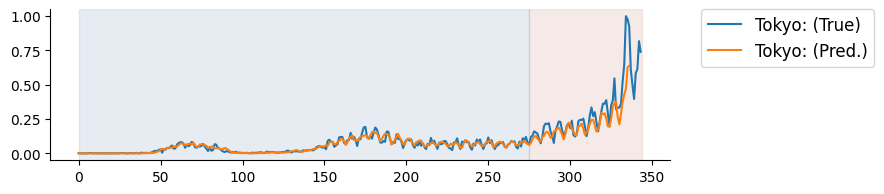

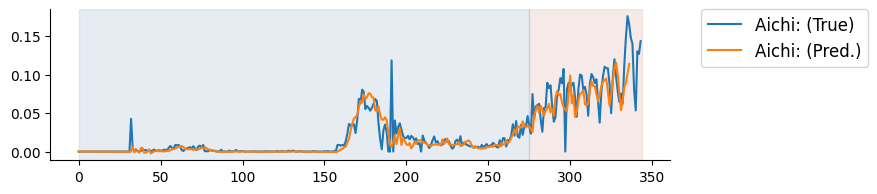

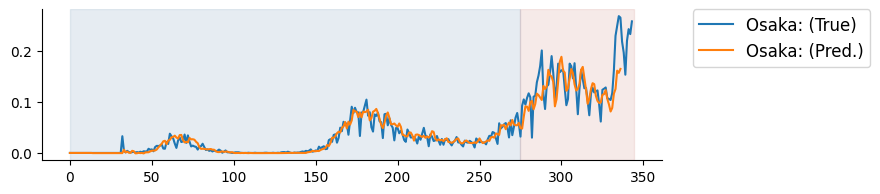

In [497]:
plot_list = ['Tokyo', 'Aichi', 'Osaka']
for sam in plot_list:
    plt, ax, fig = plt_config(x_size=8, y_size=2) # 15, 5
    #背景色つけ
    ax.axvspan(0, train_days, color='#0F4C81', alpha=0.1)
    ax.axvspan(train_days, norm_data.shape[1], color='#AB3426', alpha=0.1)

    x = list(range(norm_data.shape[1]))
    # 真値
    plt.plot(x, norm_data[find_key(sam)], label=sam+': (True)')

    # 予測値
    predict = list(np.zeros(in_days))
    for n in predict_list:
        predict.append(n[find_key_v2(sam)][0])
    x = x[:len(predict)]
    plt.plot(x, predict, label=sam+': (Pred.)')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
    #plt.ylim([0,1])
    plt.show()

##可視化2

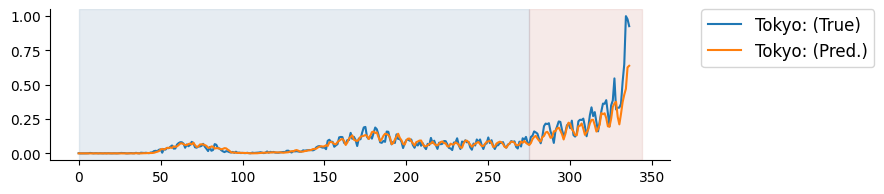

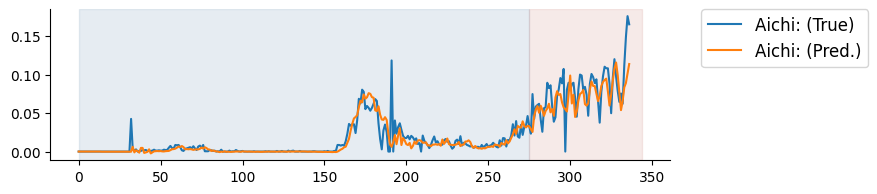

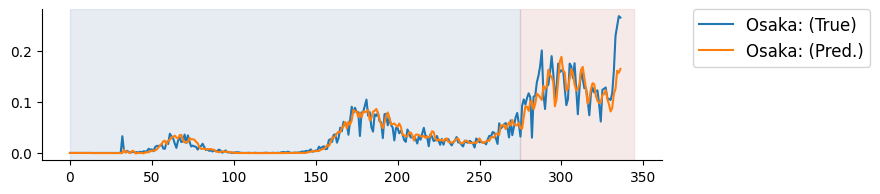

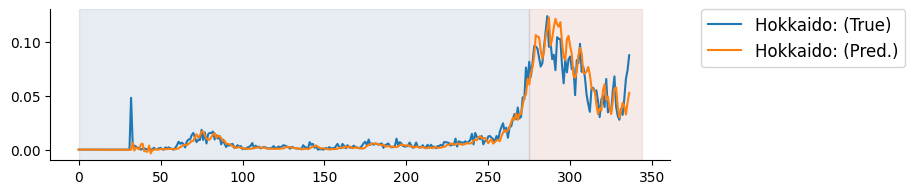

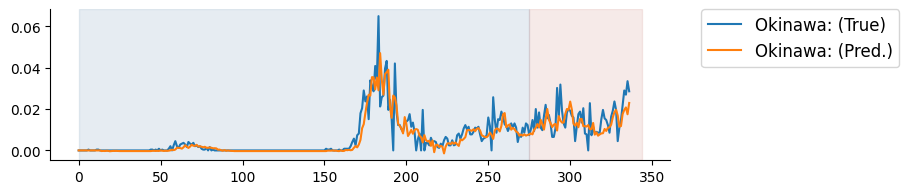

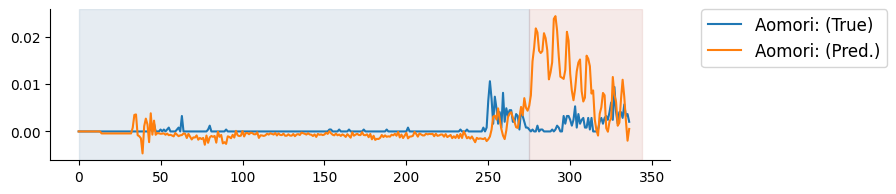

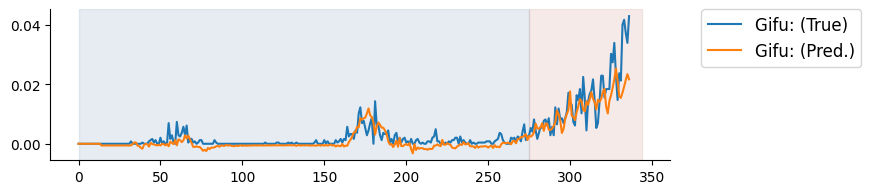

In [498]:
plot_list = ['Tokyo', 'Aichi', 'Osaka', 'Hokkaido', 'Okinawa', 'Aomori', 'Gifu']
for sam in plot_list:
    plt, ax, fig = plt_config(x_size=8, y_size=2) # 15, 5
    #背景色つけ
    ax.axvspan(0, train_days, color='#0F4C81', alpha=0.1)
    ax.axvspan(train_days, norm_data.shape[1], color='#AB3426', alpha=0.1)
    
    x = list(range(norm_data.shape[1]-out_days))
    # 真値
    plt.plot(x, norm_data[find_key(sam), :len(x)], label=sam+': (True)')

    # 予測値
    predict = list(np.zeros(in_days))
    for n in predict_list:
        predict.append(n[find_key_v2(sam)][0])
    plt.plot(x, predict, label=sam+': (Pred.)')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
    #plt.ylim([0,1])
    plt.show()

#未来予想図II

##最後を予測

In [499]:
x = np.array(test_data)
x = x[:, -in_days:].transpose(1, 0)
x = torch.tensor(x).unsqueeze(0)

model.eval()
predict_list = []
append=predict_list.append
with torch.no_grad():
    x = x.to(dtype=torch.float).cuda()
    output = model(x, A)
    pred = output.detach().cpu().numpy().transpose(0, 2, 1)
    for d in pred:
        append(d.tolist())

##プロット

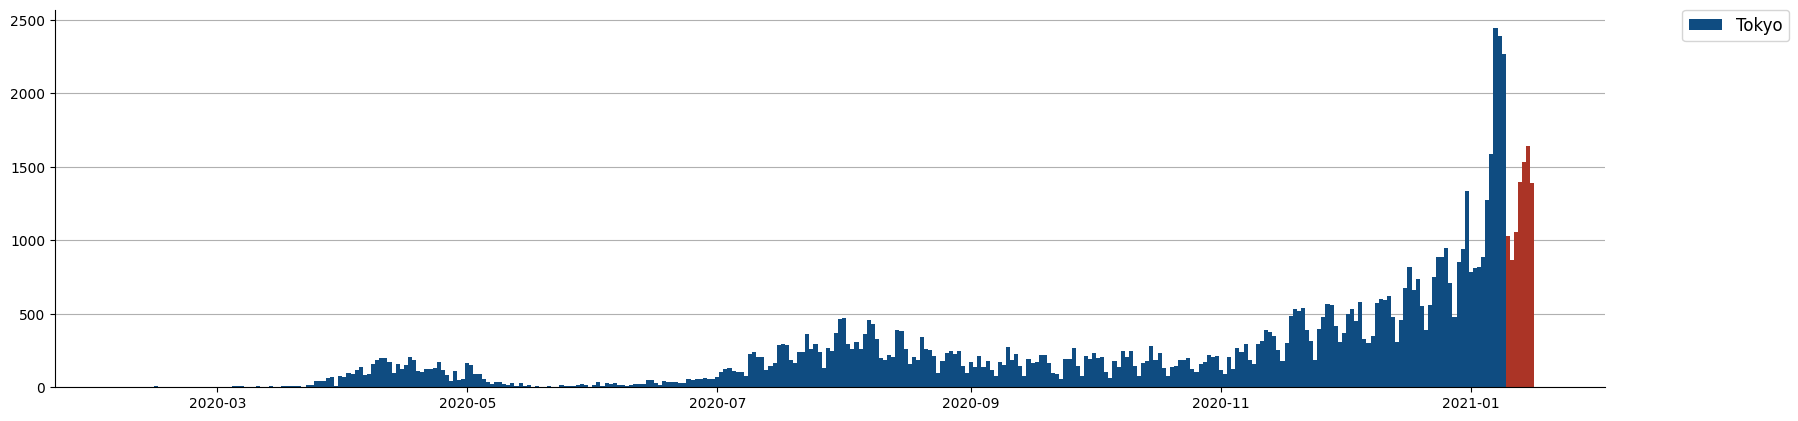

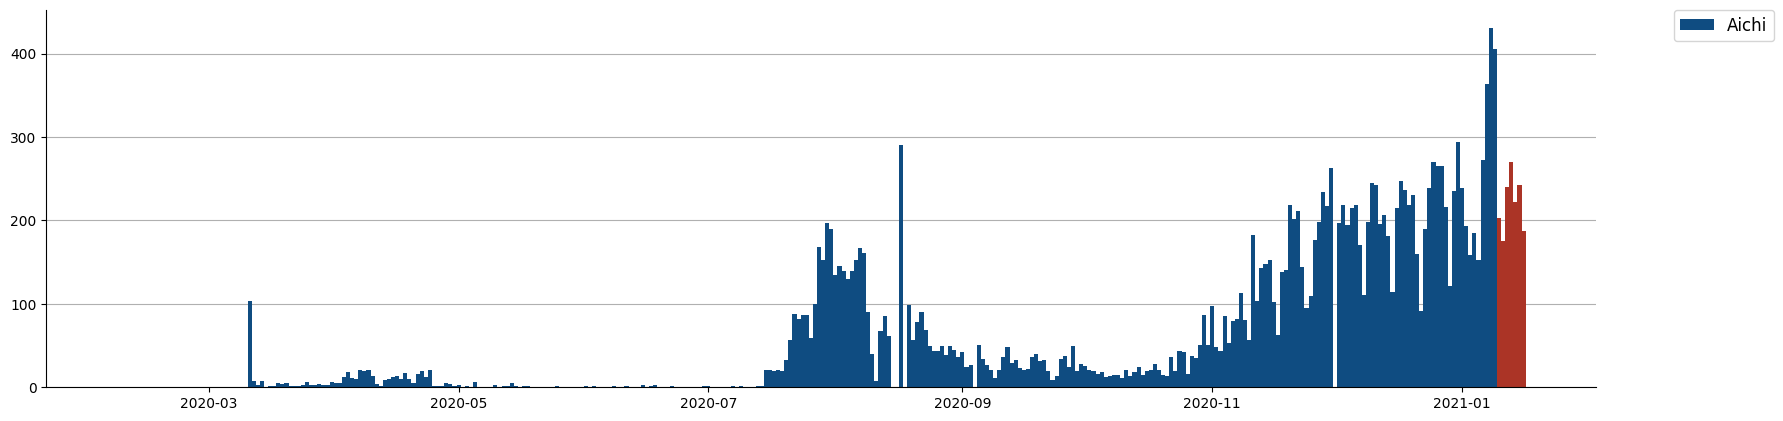

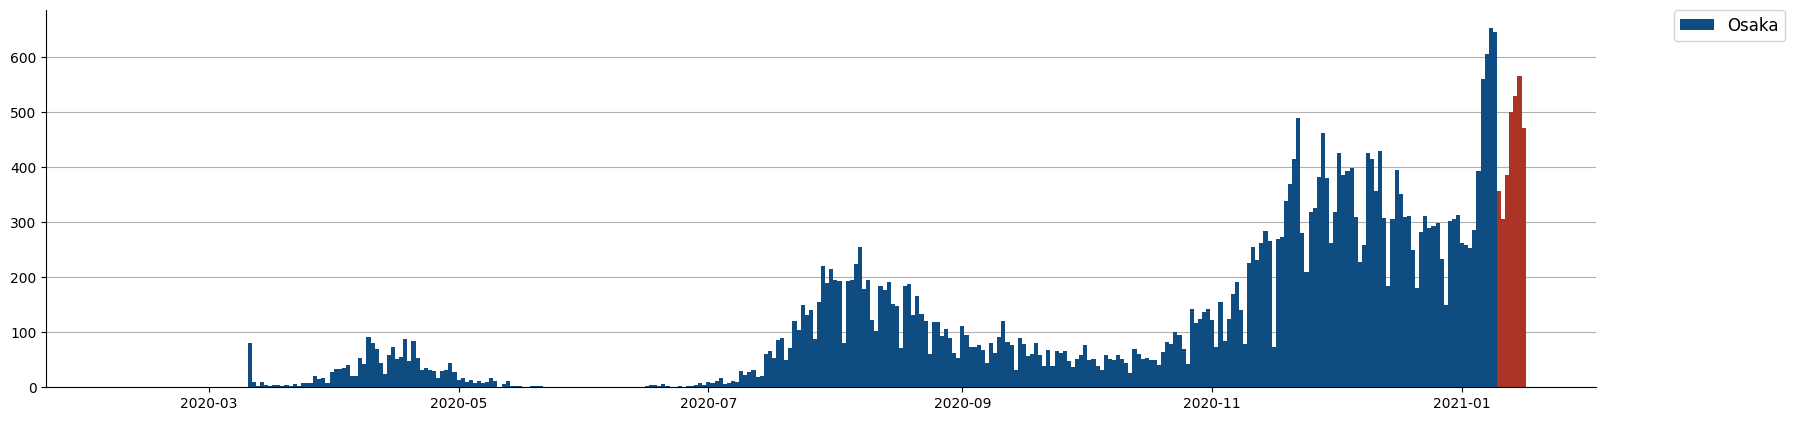

In [512]:
plot_list = ['Tokyo', 'Aichi', 'Osaka']
for sam in plot_list:
    plt, ax, fig = plt_config(x_size=20, y_size=5) # 15, 5

    x = [dt1+datetime.timedelta(days=i) for i in range(norm_data.shape[1])]
    y = DATA[find_key(sam), :-out_days].tolist()
    for value in predict_list[0][find_key_v2(sam)]:
        y.append((max_data - min_data) * value + min_data)
    bar = plt.bar(x, y, label=sam, linewidth=0, width=1, color='#0F4C81')
    for i in range(1, out_days+1):
        bar[-i].set_color('#AB3426')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
    ax.set_axisbelow(True)
    plt.grid(axis='y')
    plt.show()